In [1]:
import zipfile
import os, warnings
print(os.listdir("../input"))

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib import gridspec

from tensorflow.keras import optimizers
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import glob
from sklearn.utils import shuffle

['platesv2']


In [2]:
with zipfile.ZipFile('../input/platesv2/plates.zip', 'r') as zip_obj:
        zip_obj.extractall('/kaggle/working/') 
print(os.listdir('/kaggle/working/'))

data_root = '/kaggle/working/plates/' 
print(data_root)
print(os.listdir(data_root))

['__notebook__.ipynb', '__MACOSX', 'plates']
/kaggle/working/plates/
['.DS_Store', 'train', 'test']


In [3]:
#image dimensions and batch size
img_rows, img_cols = 224, 224 #specify width and height of the images
batch_size = 64

#training parameters
n_epochs = 5 
n_classes = 2 
validation_split = 0.2 #20% of the data for validation
verbosity = 1 #We want to be able to see the model output, verbosity=1 or True

#path specifies the location where train data is stored
path_train = "/kaggle/working/plates/train/"
#path_test specifies the location where test data is stored
path_test = "/kaggle/working/plates/"

#image input shape (w, h, d)
input_shape = (img_rows, img_cols, 3) #RGB

#cleaned and dirty labels
labels = ['cleaned', 'dirty']

#value of 10 for random number generation in Python environment
seed = 10

In [4]:
train_datagen = ImageDataGenerator(
    validation_split = validation_split,
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    validation_split = validation_split,
    rescale=1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    directory = path_train,
    classes = labels,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'training'
)

validation_generator = validation_datagen.flow_from_directory(
    directory = path_train,
    classes = labels,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_rows),
    subset = 'validation'
)

test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    classes = ["test"],
    batch_size = 1,
    class_mode=None,
    shuffle = False,
    target_size=(img_rows, img_rows)
)

Found 32 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 744 images belonging to 1 classes.


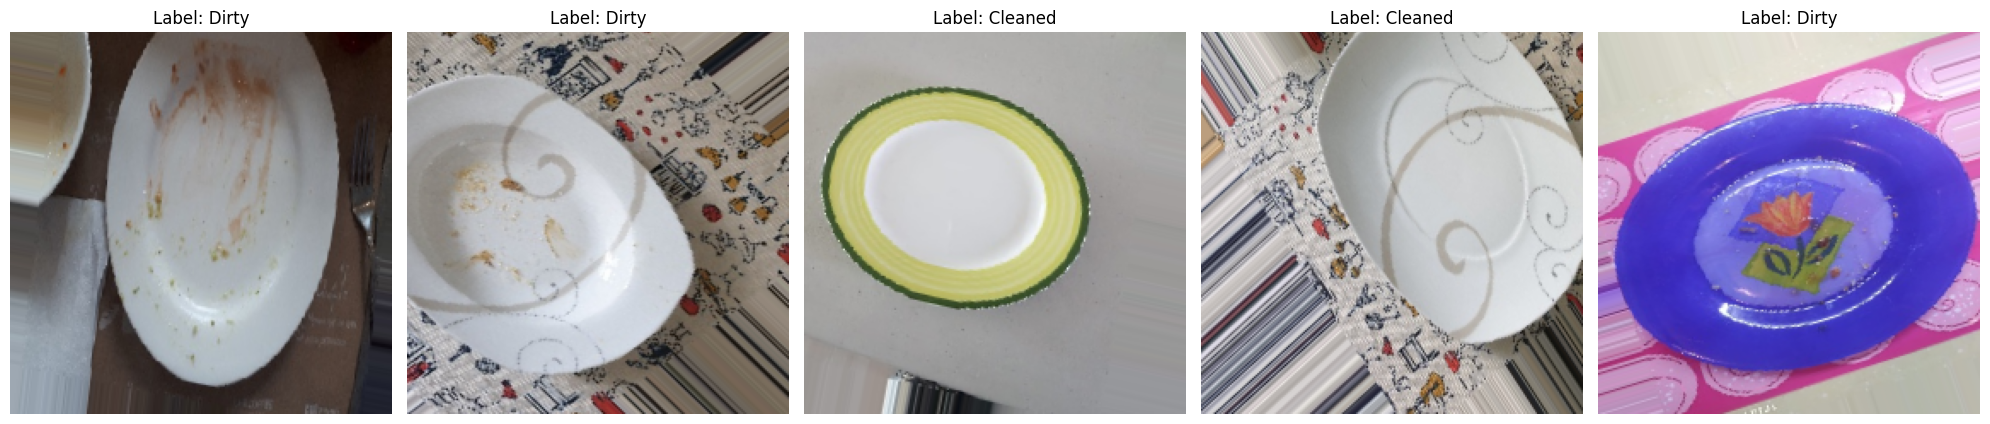

In [6]:
# Generate 5 random indexes to select batches from the train_generator
random_indices = np.random.randint(len(train_generator), size=5)

# Plot the images and print their labels
plt.figure(figsize=(20, 10))
for i, rand_idx in enumerate(random_indices):
    batch = train_generator[rand_idx]
    images = batch[0]  # Get the batch of images
    labels = batch[1]  # Get the batch of labels
    
    # Number of images in the current batch
    num_images_in_batch = images.shape[0]
    
    # Randomly select an image from the batch
    img_idx = np.random.randint(num_images_in_batch)
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[img_idx])
    plt.title('Label: {}'.format('Cleaned' if labels[img_idx] == 0 else 'Dirty'))
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
basemodel = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [8]:
#freeze all layers in a basemodel, meaning that their weights will not be updated during the training process of the entire model
for layer in basemodel.layers: 
    layer.trainable = False

In [9]:
# Build the model
model = Sequential()
model.add(basemodel)
model.add(Flatten())  
model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [10]:
# Compiling the model with the specified loss function, optimizer, and metrics
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [11]:
early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Fit the model
history = model.fit(
    train_generator,
    epochs=150,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1 #detailed updates on the training process
)

Epoch 1/150


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.5938 - loss: 10.7123 - val_accuracy: 0.6250 - val_loss: 9.7696 - learning_rate: 0.0010
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.5312 - loss: 9.5717 - val_accuracy: 0.5000 - val_loss: 9.4035 - learning_rate: 0.0010
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.6562 - loss: 8.4415 - val_accuracy: 0.5000 - val_loss: 8.7961 - learning_rate: 0.0010
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.7812 - loss: 7.4725 - val_accuracy: 0.5000 - val_loss: 8.1363 - learning_rate: 0.0010
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.7500 - loss: 6.6860 - val_accuracy: 0.5000 - val_loss: 7.4481 - learning_rate: 0.0010
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.6250 - loss: 6.1816 - val_accuracy: 0.5000 - val_loss: 6.8906 - learning_rate: 0.0010
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.6875 - loss: 5.5529 - val_accuracy: 0.3750 - va

Minimum validation loss: 1.4936041831970215


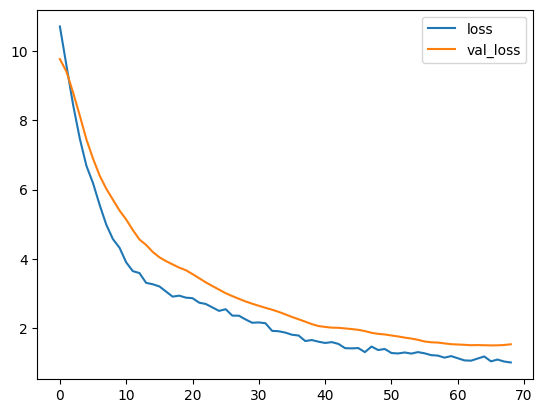

In [12]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

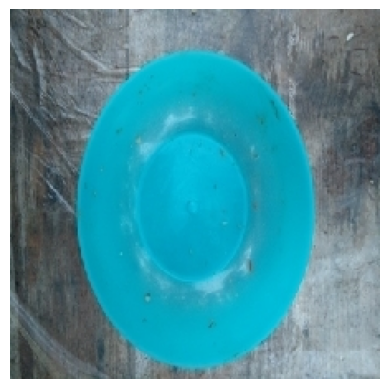

Prediction for custom image: dirty


In [13]:
# Assuming your image dimensions
IMG_DIM = (224, 224)

# Read in all O and R test images file paths. Shuffle and select 50 random test images.
test_files = glob.glob('/kaggle/working/plates/test/*.jpg')  # Adjust file extension as per your image format
test_files = shuffle(test_files)[:50]  # Shuffle and select 50 random images

# Extract images and labels
test_imgs = []
test_labels = []

for img in test_files:
    # Load and resize image
    img_array = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM))
    test_imgs.append(img_array)

# Convert lists to numpy arrays
test_imgs = np.array(test_imgs)
test_labels = np.array(test_labels)

# Standardize
test_imgs_scaled = test_imgs.astype('float32') / 255.0

# Define functions for label conversion
def class2num(label):
    return 0 if label == 'cleaned' else 1

def num2class(num):
    return 'cleaned' if num < 0.5 else 'dirty'

# Convert labels to numerical format for model training
test_labels_enc = np.array([class2num(label) for label in test_labels])

# Load or define your model
# model = tf.keras.models.load_model('path_to_your_model.h5')  # Make sure to load your model if it's not defined

# Predict using the model
predictions_model_history = model.predict(test_imgs_scaled, verbose=0)

# Convert predictions from probabilities to class labels
predictions_model_labels = np.array([num2class(pred[0]) for pred in predictions_model_history])

# Example of predicting on a single custom image
custom_im = test_imgs_scaled[2]  # Assuming index 2 is a valid index in your test set

plt.imshow(custom_im)
plt.axis('off')
plt.show()

# Reshape and predict with the model
custom_im = custom_im.reshape((1, IMG_DIM[0], IMG_DIM[1], 3))  # Reshape to match model input shape
prediction_custom_im = model.predict(custom_im, verbose=0)

# If predictions are probabilities, use the following line
print(f"Prediction for custom image: {num2class(prediction_custom_im[0][0])}")


In [14]:
preds = model.predict(test_generator, verbose=True)
labels = ['dirty' if x > 0.5 else 'cleaned' for x in preds]
submission_df = pd.read_csv('/kaggle/input/platesv2/sample_submission.csv')
submission_df['label'] = labels

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


744/744 ━━━━━━━━━━━━━━━━━━━━ 230s 309ms/step


In [15]:
submission_df.to_csv('submission.csv', index=False)

In [16]:
!rm -rf train val test plates

In [ ]:

# ROC Eğrisi ve AUC Skorunun hesaplanması
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Modelin olasılık tahminleri
y_prob = knn_model.predict_proba(X_test)[:, 1]

# ROC eğrisi hesaplama
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

# ROC eğrisinin çizilmesi
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:

# GridSearchCV ile hiperparametre optimizasyonu
from sklearn.model_selection import GridSearchCV

# Parametre aralıklarının tanımlanması
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# GridSearchCV kullanarak en iyi parametrelerin bulunması
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# En iyi parametreler ve doğruluk oranı
print("En iyi parametreler:", grid_search.best_params_)
print("En iyi doğruluk:", grid_search.best_score_)
